## Gold Query Writing Helper

The purpose of this notebook is to provide analysis of existing gold queries for a given database. This analysis will include the identifier coverage (amount of tables and columns covered by queries), and the clause types within the queries.

In addition to database-specific statistics, as we perform this analysis for multiple databases, it will also include high-level statistics of other analyzed database queries to compare across databases.

```
Copyright 2024 Kyle Luoma

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

#### Imports and Configurations

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import query_profiler as qp
from load_nl_questions import load_nlq_into_df
from db_util import *
from ipytree import Tree, Node

In [ ]:
config_dict = {
    "database": "NorthernPlainsFireManagement",
    "database_subname": "", # Use for schemas that should be divided into smaller modules (e.g. the SBODemo database). Set to empty string if not applicable.
    "query_dir": "./queries/",
    "load_label_df": False, # Set to true if up-to-date stats excel file is available
}
if config_dict["database_subname"] != "":
    config_dict["full_database_name"] = config_dict["database"] + "-" + config_dict["database_subname"]
else:
    config_dict["full_database_name"] = config_dict["database"]

#### Data Loading and Query Stats Generation

In [ ]:
gold_queries = load_nlq_into_df(
    "{}.sql".format(config_dict["full_database_name"]), 
    config_dict["query_dir"]
    )

In [ ]:
if 'table_list' not in locals():
    table_list = None
    if config_dict["database_subname"] != "":
        sbod_df = pd.read_excel('./schema-misc/SBODemoUS/SBOD_table_descriptions_combined_reduced.xlsx')
        sbod_df = sbod_df[sbod_df.module == config_dict['database_subname']]
        table_list = sbod_df.table.unique().tolist()

In [ ]:
if 'tables_and_columns_df' not in locals():
    tables_and_columns = get_tables_and_columns_from_sql_server_db(
        config_dict["database"],
        append_col_types=False
        )
    tables_and_columns_df = get_tables_and_columns_df(tables_and_columns)
    if table_list != None:
        tables_and_columns_df = tables_and_columns_df[tables_and_columns_df['table'].isin(table_list)]
    tables_and_columns_df['table'] = tables_and_columns_df['table'].str.lower()
    tables_and_columns_df['column'] = tables_and_columns_df['column'].str.lower()

In [ ]:
if config_dict['load_label_df'] == False:
    profiler = qp.QueryProfiler()

    df_list = []
    already_processed = []

    if 'label_df' in locals():
        already_processed = label_df['query_num'].unique().tolist()

    print(already_processed)

    for row in gold_queries.itertuples():
        if row.number not in already_processed:
            new_label_df = profiler.get_identifiers_and_labels_df(row.query_gold, row.number, include_brackets=False)
            df_list.append(new_label_df)

    if 'label_df' in locals() and len(df_list) > 0:
        new_label_df = pd.concat(df_list)
        new_label_df = new_label_df.reset_index(drop=True)
        new_label_df['stat_value'] = new_label_df['stat_value'].str.lower()
        label_df = pd.concat([label_df, new_label_df])
    elif len(df_list) > 0:
        label_df = pd.concat(df_list)
        label_df = label_df.reset_index(drop=True)
        label_df['stat_value'] = label_df['stat_value'].str.lower()
else:
    label_df = pd.read_excel(
        config_dict['query_dir'] + 'gold_stats/' + config_dict['database'] + '-stats.xlsx'
        )

[]


In [2]:
label_df.query_num.unique()


NameError: name 'label_df' is not defined

In [ ]:
export_stats = {
    "database": config_dict["full_database_name"],
}
export_label_stats = label_df
stat_cols = export_label_stats.columns.tolist()
if 'database' in stat_cols:
    stat_cols.remove('database')
export_label_stats['database'] = config_dict["full_database_name"]
export_label_stats[['database'] + stat_cols].to_excel(
    "./queries/gold_stats/{}-stats.xlsx".format(config_dict["full_database_name"]), index=False
    )

#### Schema coverage

In [ ]:
schema_tables = tables_and_columns_df.table.unique()
schema_tables = [x.lower() for x in schema_tables]
schema_columns = tables_and_columns_df.column.unique()
schema_columns = [x.lower() for x in schema_columns]

query_tables = label_df.query("stat_key == 'table'").stat_value.unique()
query_columns = label_df.query("stat_key == 'column'").stat_value.unique()

In [ ]:
table_coverage = len(set(query_tables).intersection(set(schema_tables))) / len(schema_tables)
column_coverage = len(set(query_columns).intersection(set(schema_columns))) / len(schema_columns)
print("Table coverage: {}".format(table_coverage))
print("Column coverage: {}".format(column_coverage))
export_stats['table_coverage'] = table_coverage
export_stats['column_coverage'] = column_coverage

Table coverage: 0.7777777777777778
Column coverage: 0.5174825174825175


#### Unused tables and columns

In [ ]:
unused_tables = set(schema_tables).difference(set(query_tables))
unused_columns = list(set(schema_columns).difference(set(query_columns)))
print("Unused columns by table:")
unused_tree = Tree()
for table in schema_tables:
    table_columns = tables_and_columns_df.query("table == @table").column.unique()
    if table in unused_tables:
        table_style = "danger"
    else:
        table_style = "success"
    unused_tree.add_node(
        Node(
            table, 
            [
                Node(
                    column, 
                    children=[],
                    icon="leaf"
                ) for column in table_columns if column.lower() in unused_columns
            ] + [
                Node(
                    column, 
                    children=[],
                    icon="leaf",
                    icon_style="success"
                ) for column in table_columns if column.lower() not in unused_columns
            ],
            opened=False,
            icon="table",
            icon_style=table_style
        )
    )
unused_tree
    

Unused columns by table:


Tree(nodes=(Node(icon='table', icon_style='success', name='tbl_deadwood', nodes=(Node(icon='leaf', name='data_…

#### Query Clause Stats

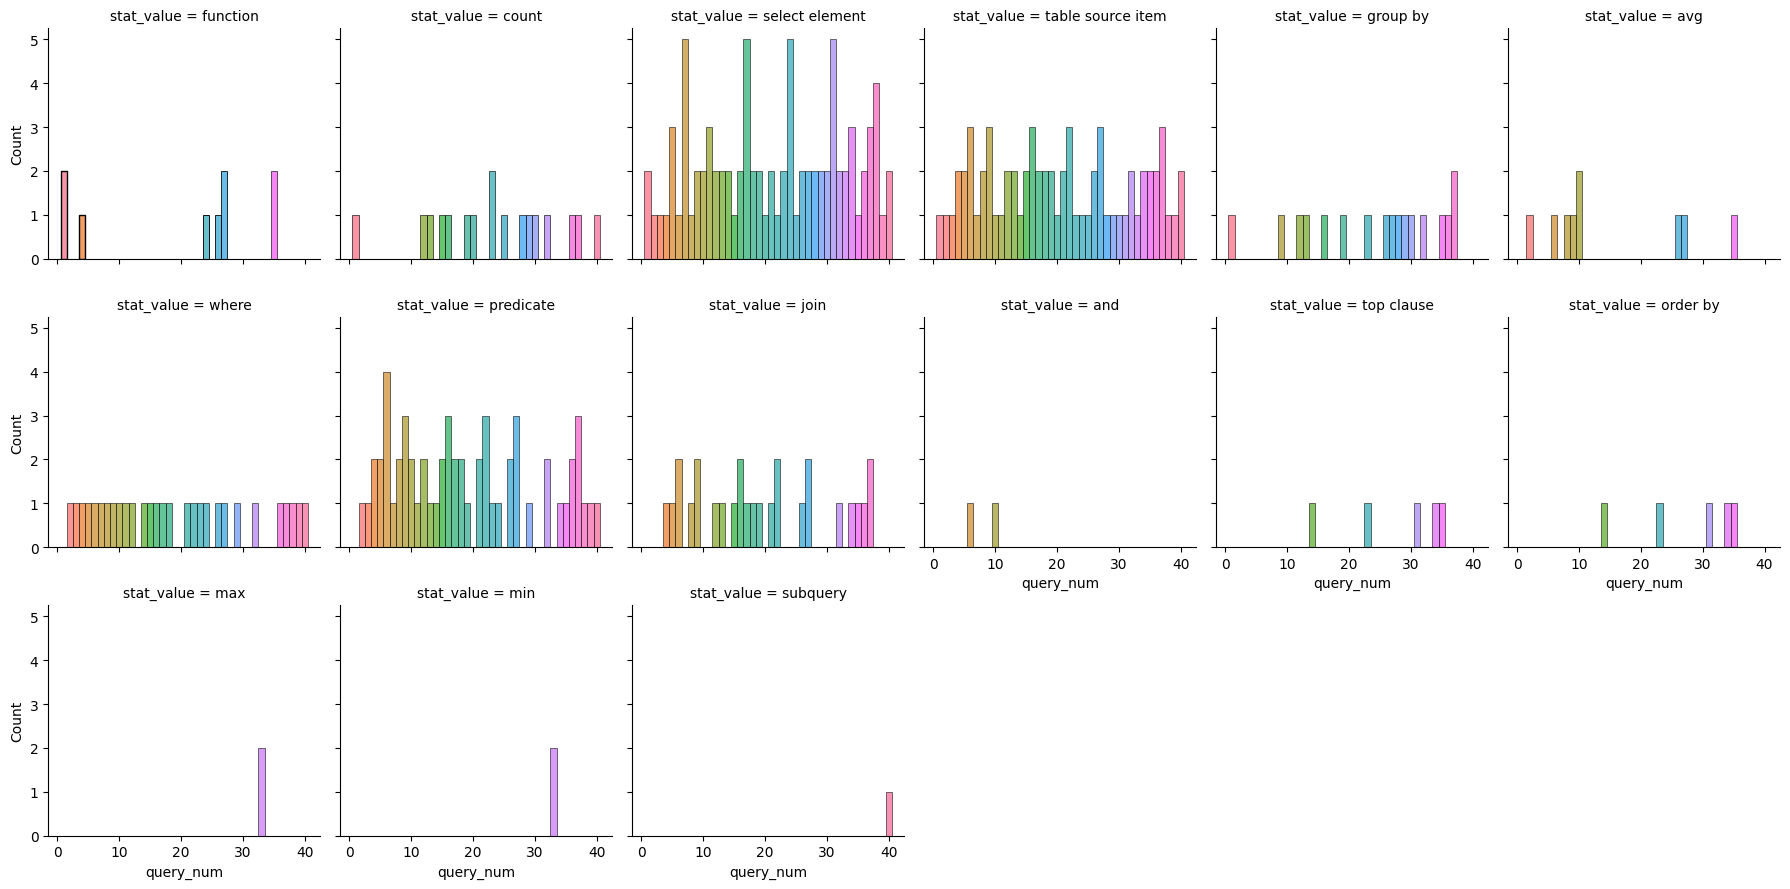

In [ ]:
plot_df = label_df.query("stat_key != 'table' & stat_key != 'column'")

g = sns.FacetGrid(plot_df, col="stat_value", col_wrap=6, 
                  sharex=True, sharey=True, hue="query_num"
                  )
g.map(sns.histplot, "query_num", discrete=True)

In [ ]:
# Get a count of stats per query then wrangle the data into submission in 
# order to create a sorting column by count of stats per query
# that we use as the x axis on the histogram below
plot_df = label_df.query("stat_key != 'table' & stat_key != 'column'")
stat_counts = plot_df.groupby(['query_num']).count().reset_index()[['query_num', 'stat_key']]
stat_counts.rename(columns={'stat_key': 'num_stats'}, inplace=True)
stat_counts.sort_values(by=['num_stats'], inplace=True)
stat_counts.reset_index(inplace=True, drop=True)
stat_counts.reset_index(inplace=True, drop=False)
stat_counts.rename(columns={'index': 'query_sort'}, inplace=True)
stat_counts.set_index('query_num', inplace=True, drop=True)
plot_df = plot_df.merge(stat_counts, on='query_num')
plot_df.reset_index(inplace=True, drop=True)


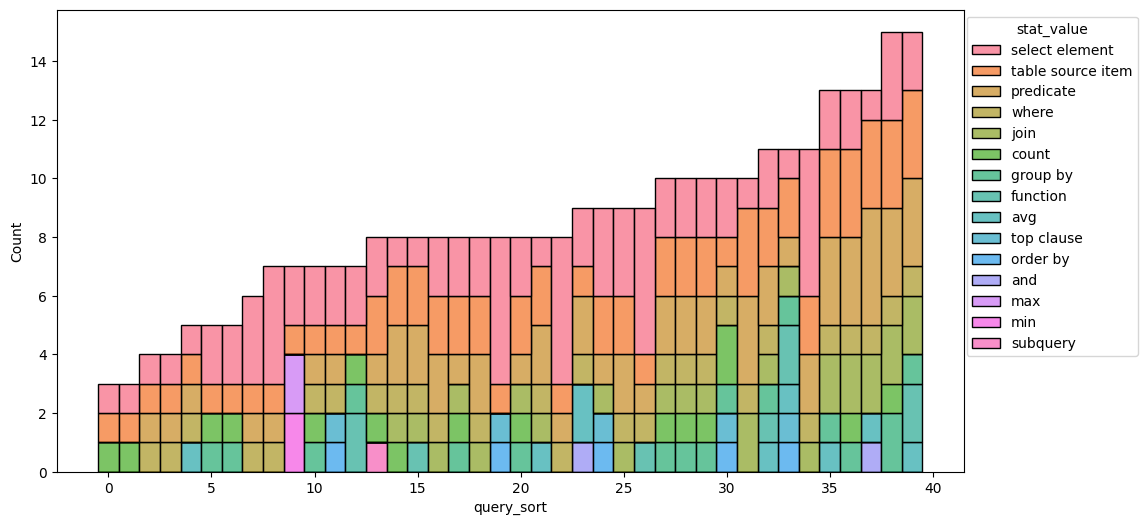

In [ ]:
fig, ax = plt.subplots(figsize=(11.7, 6))
hist_plot = sns.histplot(
    plot_df,
    x="query_sort", 
    hue="stat_value", 
    multiple="stack", 
    discrete=True,
    stat="count",
    hue_order=plot_df.stat_value.value_counts().index,
    )
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))
fig = hist_plot.get_figure()
fig.savefig("./queries/gold_stats/{}-stats-clause-counts.png".format(config_dict["database"]), dpi=300)